# Logistic Map

The logistic map is a polynomial mapping (equivalently, recurrence relation) of degree 2, often cited as an archetypal example of how complex, chaotic behaviour can arise from very simple non-linear dynamical equations. 
The map was popularized in a seminal 1976 paper by the biologist Robert May [1]. Mathematically, the logistic map is written:

$$y[n] = \theta\cdot y[n-1]\cdot (1-y[n-1])$$

It will be shown how the parameter $\theta$ from this model may be estimated minimizing simulation
error.

- [1] May, Robert M. 1976. "Simple mathematical models with very complicated dynamics." Nature 261(5560):459-467.

In [1]:
from simident import narx
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from joblib import Parallel, delayed
import multiprocessing
import matplotlib as mpl
num_cores = multiprocessing.cpu_count()
%matplotlib inline

## Defining a Custom NARX Model

When estimating
the parameters of a NARX model one could use a predefined model structure (e.g. Linear,
Polynomial or Neural-Network models), or could create their on custom model structure,
as will be done at this example.

A NARX model is a model for which the current output depend on the previous outputs
and on the previous inputs (NARX stands for non-linear autoregressive with exogenous inputs model).
The ``simulation-error-identification`` library define an abstract class called NarxModel.

The logistic map will be modeled as a NarxModel without inputs.

In [2]:
class LogisticMap(narx.NarxModel):
    """Logistic map model"""
    
    def __init__(self):
        """Constructor"""
        
        N = 1 # model dynamic order
        Ny = 1 # one input
        M = 0 # the model doesn't have any inputs
        Nu = 0 # the model doesn't have any inputs
        delay = 0# the model doesn't have any inputs
        Nparams = 1 # There are only one parameter
        
        narx.NarxModel.__init__(self, Nparams, N, M, Ny, Nu, delay)
        
    def __call__(self, y, u, params):
        """
        Function that define the logistic map model:

        y[n] = theta*y[n-1]*(1-y[n-1])
        """
        y, u, params = self._arg_check(y, u, params)
        
        theta = params[0]
        ynext = theta*y*(1 - y)
        
        return ynext
        
    
    def derivatives(self, y, u, params, deriv_y=True, deriv_u=True, deriv_params=True):
        """
        Function that define the logistic map derivatives. 
        When defining a custom model this method is optional 
        and if not defined a numerical aproximation of the 
        derivatives will be used.
        
        But since the the logistic map have a nice polynomial structure
        it is very easy to define its first derivatives, as shown next:
        """
        y, u, params = self._arg_check(y, u, params)
        
        # Parameter
        theta = params[0]
        
        
        returns = []
        if deriv_y:  # Derivatives in relation to y 

            # d(theta*y[n-1]*(1-y[n-1]))/dy = theta - 2*theta*y 
            dy = theta - 2*theta*y 
            
            # add to returns
            returns.append(np.atleast_3d(dy))
            
        
        if deriv_u:  # Derivatives in relation to u (empty)

            # thera are not any inputs
            du = []

            # add to returns
            returns.append(np.atleast_3d(du))
            
        if deriv_params:  # Derivatives in relation to theta 

            # d(theta*y[n-1]*(1-y[n-1]))/dtheta = y[n-1]*(1-y[n-1])
            dparams = y*(1 - y)
            
            # add to returns
            returns.append(np.atleast_3d(dparams))
            
        return returns

Its always good too check if the derivative calculation is right, as done above:

In [3]:
# Check derivative
mdl = LogisticMap()
theta_list = [2, 3.2, 3.6]
y_list = [0, 0.2, 0.5, 0.7, 0.9]
for theta in theta_list:
    for y in y_list:
        dy, dparams = mdl.derivatives([[y]], [[]], [theta], deriv_u=False)
        dy_numeric, dparams_numeric = mdl._numeric_derivatives([[y]], [[]], [theta], deriv_u=False)
        if np.abs(dy-dy_numeric) > 10**(-4):
            print("Wrong Derivative")
        if np.abs(dparams-dparams_numeric) > 10**(-4):
            print("Wrong Derivative")

## Simulating the Logistic Map

Having defined the correspondent NARX model, the logistic map will be simulated 
for an initial condition $y[0] = 0.5$ and a parameter $\theta = 3.78$

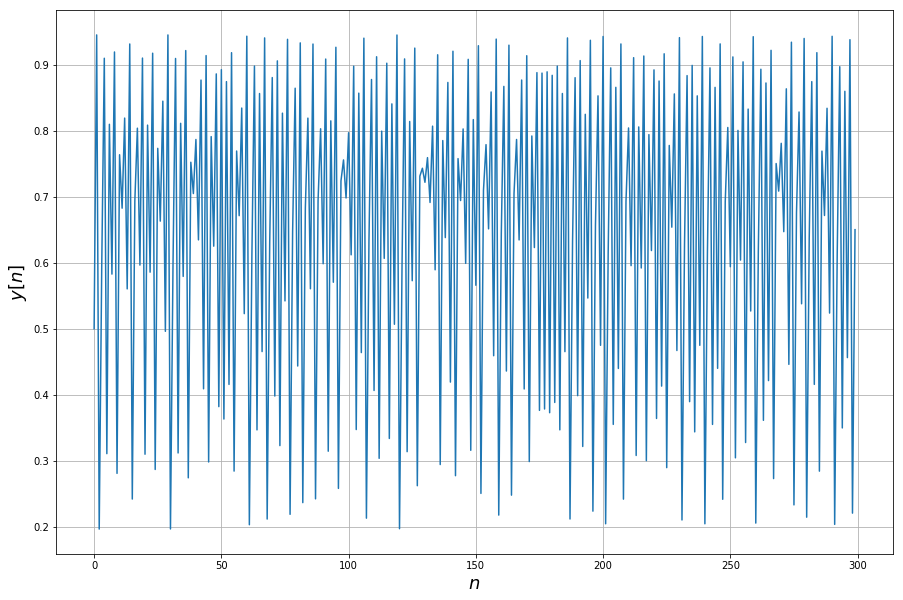

In [4]:
# Define Logistic Map model
mdl = LogisticMap()

# Initial conditions
y0 = [[0.5]]

# simulation length
simlen = 300

# There are no input
u = np.reshape([], (simlen, 0))

# the parameter is theta = 3.78
theta = [3.78]

# Simulate
y = narx.simulate(mdl, y0, u, theta)

# Assemble data
y = np.vstack((y0, y[:-2]))


y[y>1] = 0.99
y[y<0] = 0.01

# Plot
plt.figure(figsize=(15, 10))
plt.plot(y)
plt.grid()
plt.xlabel("$n$", fontsize=18)
plt.ylabel("$y[n]$", fontsize=18)
plt.show()

In [5]:
# Define error object
shootlen=1
sim_error = narx.SimulationError(mdl, y, u, shootlen)
initial_guess=3.6
tr_options ={}
tr_options['atol'] = 1e-12
params, info = sim_error.lsq_estimate_parameters([initial_guess], verbose=2, tr_options=tr_options, use_jacobian=True)
print(params)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3734e+00                                    3.75e+01    
       1              2         3.3377e-07      3.37e+00       1.80e-01       1.42e-03    
       2              3         3.6697e-13      3.34e-07       6.66e-04       8.76e-06    
       3              4         3.1414e-25      3.67e-13       2.24e-07       8.29e-13    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 3.3734e+00, final cost 3.1414e-25, first-order optimality 8.29e-13.
[ 3.78]


# Simulation Error and Multiple Shooting

Supposing that the above simulation with $\theta = 3.78$ is measured data. Using this 'measured data' we would like to estimate the parameter $\hat{\theta}$ such that the error between the system simulation of: 
$$\hat{y}[n] = \hat{\theta}\cdot \hat{y}[n-1]\cdot (1-\hat{y}[n-1])$$
and the 'measured data' is as small as it can be. Of course, this error will be zero for 
$\hat{\theta} = \theta = 3.78$.

Consider the error:
$$e[n] = \hat{y}[n] - y[n]$$
The figures below show the sum of square errors for three different cases:
- With the same initial conditions, both systems are simulated through the entire section. The error is the difference between this simulation and the 'measured data'.
- The data is divided into 10 intervals and the system is simulated in each one of those. The error is the difference between this simulation in the subintervals and the 'measured data'.
- The data is divided into 20 intervals and the system is simulated in each one of those. The error is the difference between this simulation in the subintervals and the 'measured data'.

While the global minimum for the three error surfaces occurs at $\hat{\theta} = 3.78$, the error surface is very different for the three cases. For one single shooting (simulation through the entire interval), the error surface can became very intricate for  $\hat{\theta} \in [3.6, 4.0]$ and a gradient descent approach to find the error minimum  would be very dependent on the initial guess. The error surface become less complex for 10 shoots and for 20 shoots a gradient descent approach could find the global minimum for any initial guess.

Overflow occur for the single shooting case because parameters for which the system become unstable are probed by the optimization algorithm.

In [11]:
# Length of simulation intervals
list_shootlen = [300, 10, 3, 1]

# List of parameters theta used to compute the error
list_theta = np.hstack((np.linspace(0, 3.78, 500), np.linspace(3.78, 4, 500)))

# List of initial guess
np.random.seed(0)
list_initial_guess = np.random.uniform(0, 4, 100)

# Define function
def sum_of_squared_errors(theta, initial_conditions, sim_error):
    extended_parameter = narx.assemble_extended_params([theta], initial_conditions)
    error_ms = sim_error(extended_parameter)
    return sum(error_ms**2)

# Define function
def estimate_parameters(initial_guess, sim_error):
    tr_options ={}
    tr_options['atol'] = 1e-12
    params, info = sim_error.lsq_estimate_parameters([initial_guess], tr_options=tr_options, max_nfev=200)
    if np.isnan(params[0]) or np.isinf(params[0]):
        return -1
    else:
        return params

sse = []
params_list = []
for k, shootlen in enumerate(list_shootlen):
    # Define error object
    sim_error = narx.SimulationError(mdl, y, u, shootlen)
    
    # Get initial conditions from data
    initial_conditions = narx.initial_conditions_from_data(y, sim_error.multiple_shoots, mdl.N, max(mdl.N, mdl.M))
    
    # Compute sum of square errors (sse) for each parameter on the list
    sse += [Parallel(n_jobs=num_cores)(delayed(sum_of_squared_errors)(theta, initial_conditions, sim_error) for theta in list_theta)]

    params_list += [Parallel(n_jobs=num_cores)(delayed(estimate_parameters)(initial_guess, sim_error) for initial_guess in list_initial_guess)]
        

/home/antonio/.virtualenvs/multiple-shooting/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
/home/antonio/.virtualenvs/multiple-shooting/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
/home/antonio/.virtualenvs/multiple-shooting/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
/home/antonio/.virtualenvs/multiple-shooting/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
/home/antonio/.virtualenvs/multiple-shooting/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
/home/antonio/.virtualenvs/multiple-shooting/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
/home/antonio/.virtualenvs/multiple-shooting/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarnin

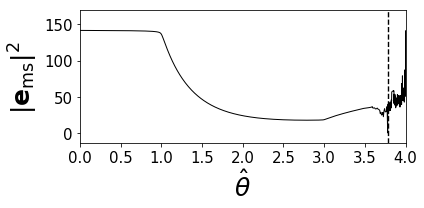

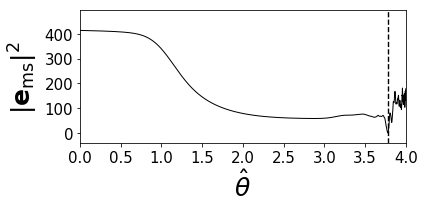

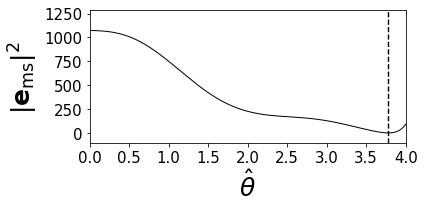

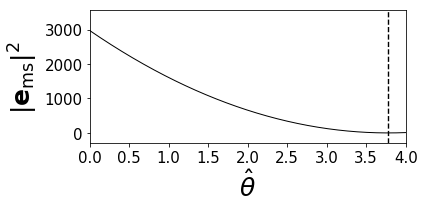

In [12]:
# Plot       
for k in [0, 1, 2, 3]:
    plt.figure(figsize=(6, 3))
    plt.plot(list_theta, sse[k], 'k', lw=1)
    plt.xlabel(r"$\hat{\theta}$", fontsize=25)
    plt.ylabel(r"$\|\mathbf{e}_{\rm ms}\|^2$", fontsize=25)
    plt.xlim([0, 4])
    plt.ylim([-0.1*max(sse[k]), 1.2*max(sse[k])])
    plt.axvline(3.78, ls='--',  lw=1.4, color='k')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()

plt.tight_layout()
plt.show()

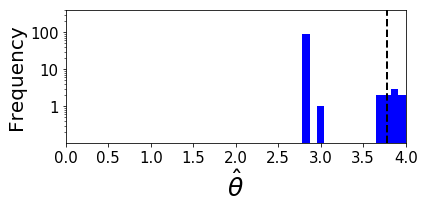

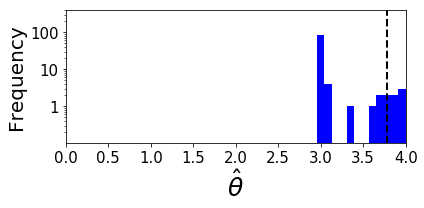

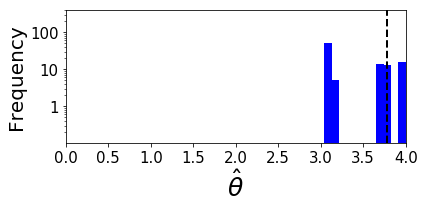

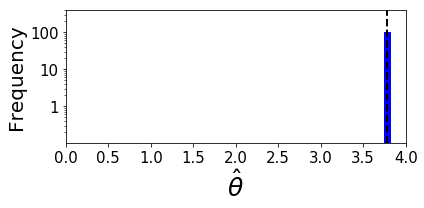

In [13]:
# Plot       
for k in [0, 1, 2, 3]:
    plt.figure(figsize=(6, 3))
    plt.hist(np.atleast_1d(params_list[k]), np.linspace(0, 4, 47), color='b', log=True)
    plt.ylabel(r"Frequency", fontsize=20)
    plt.xlabel(r"$\hat{\theta}$", fontsize=25)
    plt.xlim([0, 4])
    plt.ylim([1e-1, 4e2])
    plt.axvline(3.78, ls='--',  lw=2, color='k')
    plt.yticks([1, 10, 100],['1', '10', '100'], fontsize=15)
    plt.xticks(fontsize=15)
    plt.tight_layout()

plt.tight_layout()
plt.show()